# PyTorch 糖尿病預測 Notebook

此 Notebook 示範如何使用 PyTorch 訓練一個簡單的線性回歸模型來預測糖尿病進展。

In [13]:
# 匯入必要的庫
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# 載入和預處理數據
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割訓練和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 轉換為 PyTorch 張量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# 自定義 Dataset
class DiabetesDataset(torch.utils.data.Dataset):
    """將特徵和目標張量包裝成 PyTorch Dataset."""
    def __init__(self, X_tensors, y_tensor):
        self.features = X_tensors
        self.targets = y_tensor
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [ ]:
# 建立 DataLoader
train_dataset = DiabetesDataset(X_train_tensor, y_train_tensor)
test_dataset = DiabetesDataset(X_test_tensor, y_test_tensor)
batch_size = 32
num_workers = 0
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [15]:
# 定義簡單的線性回歸模型
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel(X_train.shape[1])

In [ ]:
# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 訓練模型並收集損失
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 3330.4019
Epoch [200/1000], Loss: 2906.5916
Epoch [300/1000], Loss: 2896.9121
Epoch [400/1000], Loss: 2895.6240
Epoch [500/1000], Loss: 2894.6233
Epoch [600/1000], Loss: 2893.6736
Epoch [700/1000], Loss: 2892.7600
Epoch [800/1000], Loss: 2891.8799
Epoch [900/1000], Loss: 2891.0322
Epoch [1000/1000], Loss: 2890.2153
Epoch [800/1000], Loss: 2891.8799
Epoch [900/1000], Loss: 2891.0322
Epoch [1000/1000], Loss: 2890.2153


In [ ]:
# 評估模型
model.eval()
test_precisions = []
test_targets = []
total_test_loss = 0.0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_test_loss += loss.item() * batch_X.size(0)
        test_precisions.append(outputs.numpy())
        test_targets.append(batch_y.numpy())
final_precisions = np.concatenate(test_precisions, axis=0)
final_targets = np.concatenate(test_targets, axis=0)
avg_test_loss = total_test_loss / len(test_loader.dataset)
print(f'Test Loss: {avg_test_loss:.4f}')
    
# 計算 R² 分數
ss_tot = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
ss_res = torch.sum((y_test_tensor - torch.tensor(final_precisions))**2)
r2 = 1 - (ss_res / ss_tot)
print(f'R² Score: {r2.item():.4f}')

Test Loss: 2885.9492
R² Score: 0.4553


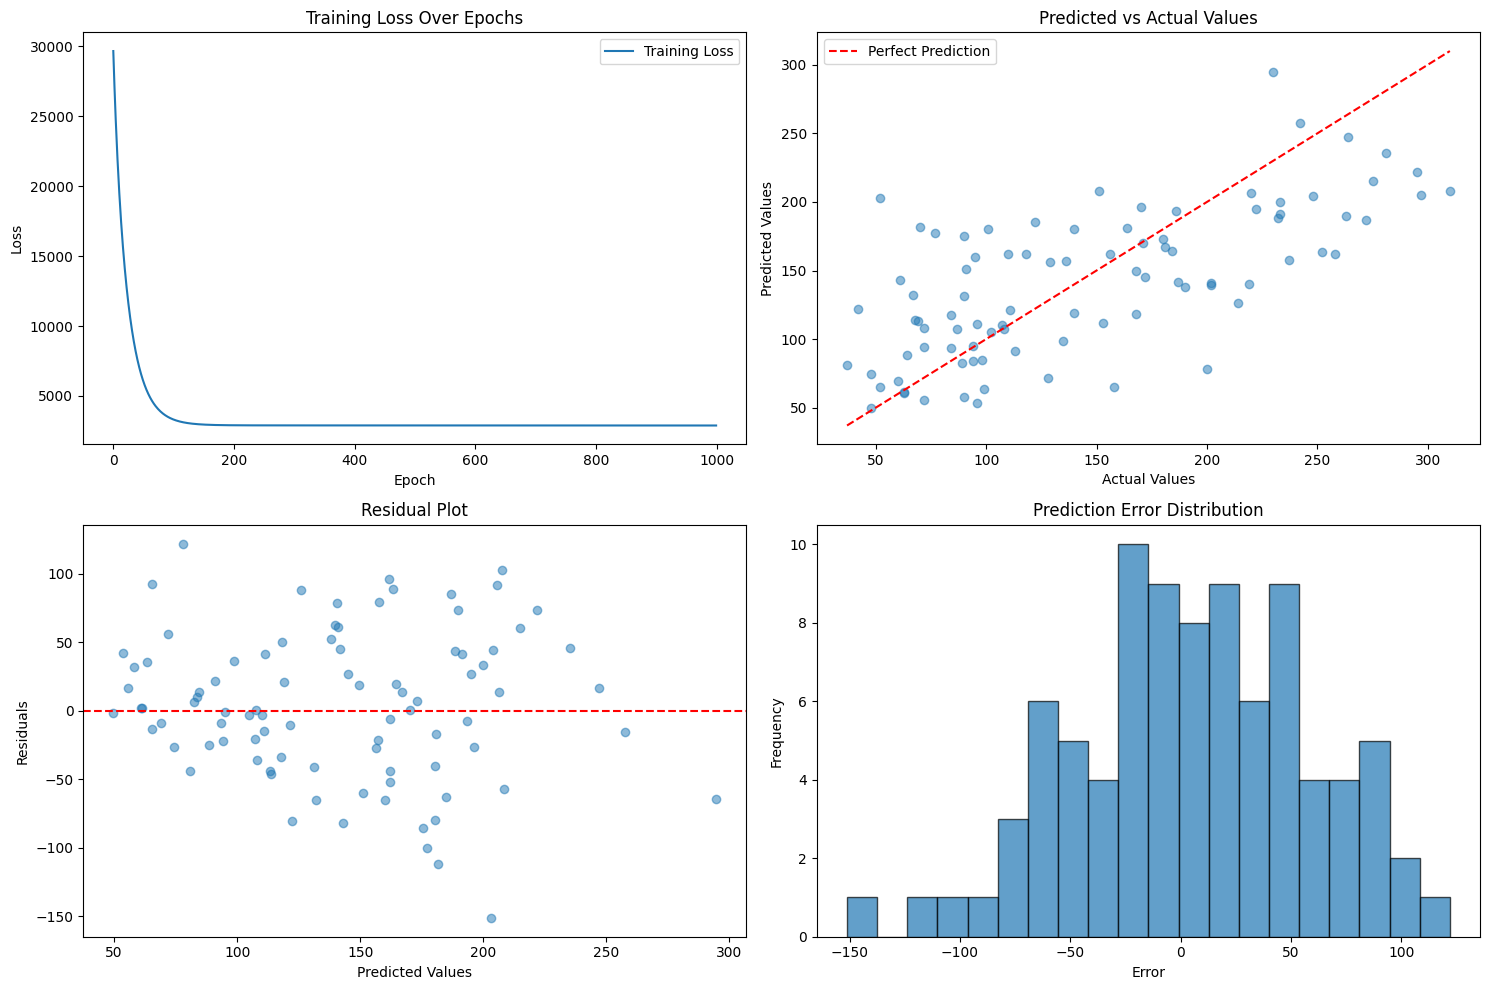

In [ ]:
# 視覺化
plt.figure(figsize=(15, 10))

# 訓練損失曲線
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 預測 vs 實際值散點圖：橫軸實際值，縱軸預測值，點分佈顯示預測準確性，紅色虛線為完美預測線
plt.subplot(2, 2, 2)
plt.scatter(final_targets, final_precisions, alpha=0.5)
plt.plot([final_targets.min(), final_targets.max()], [final_targets.min(), final_targets.max()], 'r--', label='Perfect Prediction')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# 殘差圖 (Residual Plot)
residuals = final_targets - final_precisions
plt.subplot(2, 2, 3)
plt.scatter(final_precisions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# 預測誤差分佈直方圖
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('diabetes_visualization.png')
plt.show()